In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, microwave_coupling_matrix, generate_laser_D, generate_microwave_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [3]:
script_dir = Path().parent.absolute().parent

In [4]:
script_dir

WindowsPath('C:/Users/ogras/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [5]:
#Define what states are to be included in the simulation
Js_g = [0,1,2,3] # J values to be included
I_F = 1/2 #Fluorine nuclear spin
I_Tl = 1/2 #Thallium nuclear spin

#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

In [6]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [7]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [8]:
parity = lambda J: (-1)**J

# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation.

In [9]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [3/2]
F_excited = [2]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

In [10]:
for s in excited_states_approx:
    s.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [11]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [12]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [13]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [14]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; P(2), F$_1$'=3/2, F'=2

In [15]:
#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
# excited_states_laser_approx = [1*CoupledBasisState(
#                                 F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
#                                 )
#                             ]
excited_states_laser_approx = excited_states_approx

In [16]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=2,F1=3/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = +1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=2,mF=1,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [17]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [18]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0
H_laser_z_1[np.abs(H_laser_z_1) < 1e-6] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-6] = 0

In [19]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.07693482671232137+0j)
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000-0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.8482+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5294+0.0000j x |B, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [20]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

## J12 microwaves

In [21]:
# Define ground states for microwaves
Js = [2]
ground_states_microwave1_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

# Define excited states for microwaves
Je = [1]
excited_states_microwave1_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Je
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

In [22]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_μ1_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0)
excited_μ1_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0)

In [23]:
ground_states_μ1 = find_exact_states(
                                ground_states_microwave1_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_μ1 = find_exact_states(
                                excited_states_microwave1_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_μ1_z = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ1, 
                                    excited_states = excited_states_μ1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_μ1_y = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ1, 
                                    excited_states = excited_states_μ1, 
                                    pol_vec = np.array([0,1,0]), 
                                    reduced = False
                                    )

In [24]:
# set small values to zero
H_μ1_z[np.abs(H_μ1_z) < 1e-3*np.max(np.abs(H_μ1_z))] = 0
H_μ1_y[np.abs(H_μ1_y) < 1e-3*np.max(np.abs(H_μ1_y))] = 0

In [25]:
ground_μ1_main = find_exact_states([ground_μ1_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_μ1_main = find_exact_states([excited_μ1_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_μ1_main = ED_ME_mixed_state(
                        ground_μ1_main, excited_μ1_main, pol_vec = np.array([0,0,1])
                        )

ground_μ1_main_idx = QN.index(ground_μ1_main)
excited_μ1_main_idx = QN.index(excited_μ1_main)

print(ME_μ1_main)
ground_μ1_main_approx.print_state()
print('-'*100)
ground_μ1_main.print_state()
print('='*100)
excited_μ1_main_approx.print_state()
print('-'*100)
excited_μ1_main.print_state()

(0.4934218597083703+0j)
+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9983+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>


In [26]:
D_μ1 = generate_microwave_D(H_rot, QN, ground_μ1_main, excited_μ1_main, excited_states_μ1, Δ = 0)

## J23 microwaves

In [27]:
# Define ground states for microwaves
Js = [2]
ground_states_microwave2_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

# Define excited states for microwaves
Je = [3]
excited_states_microwave2_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Je
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

In [28]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_μ2_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**2, Omega = 0)
excited_μ2_main_approx = 1*CoupledBasisState(J=3,F1=7/2,F=3,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**3, Omega = 0)

In [29]:
ground_states_μ2 = find_exact_states(
                                ground_states_microwave2_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_μ2 = find_exact_states(
                                excited_states_microwave2_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_μ2_z = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ2, 
                                    excited_states = excited_states_μ2, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_μ2_y = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ2, 
                                    excited_states = excited_states_μ2, 
                                    pol_vec = np.array([0,1,0]), 
                                    reduced = False
                                    )

In [30]:
# set small values to zero
H_μ2_z[np.abs(H_μ2_z) < 1e-3*np.max(np.abs(H_μ2_z))] = 0
H_μ2_y[np.abs(H_μ2_y) < 1e-3*np.max(np.abs(H_μ2_y))] = 0

In [31]:
ground_μ2_main = find_exact_states([ground_μ2_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_μ2_main = find_exact_states([excited_μ2_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_μ2_main = ED_ME_mixed_state(
                        ground_μ2_main, excited_μ2_main, pol_vec = np.array([0,0,1])
                        )

ground_μ2_main_idx = QN.index(ground_μ2_main)
excited_μ2_main_idx = QN.index(excited_μ2_main)

print(ME_μ2_main)
ground_μ2_main_approx.print_state()
print('-'*100)
ground_μ2_main.print_state()
print('='*100)
excited_μ2_main_approx.print_state()
print('-'*100)
excited_μ2_main.print_state()

(0.4960095327522461+0j)
+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9983+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 3, F1 = 7/2, F = 3, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9991+0.0000j x |X, J = 3, F1 = 7/2, F = 3, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>


In [32]:
D_μ2 = generate_microwave_D(H_rot, QN, ground_μ2_main, excited_μ2_main, excited_states_μ2, Δ = 0)

## Total Hamiltonian

In [33]:
# shift energies in H_rot in accordance with the rotating frame
# also shift the energies so that ground_main is at zero energy
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot += D1 + D_μ1 + D_μ2

## Collapse Operators

In [34]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]


## Generate Symbolic Hamiltonian

In [35]:
t = Symbol("t", real = True)

Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z

Pμy1 = Function("Pμy1")(t) # Polarization switching function for y
Pμz1 = Function("Pμz1")(t) # Polarization switching function for z

Pμy2 = Function("Pμy2")(t) # Polarization switching function for y
Pμz2 = Function("Pμz2")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1)]
microwave_fields = [(H_μ1_z*Pμz1, ME_μ1_main), (H_μ1_y*Pμy1, ME_μ1_main), 
                    (H_μ2_z*Pμz2, ME_μ2_main), (H_μ2_y*Pμy2, ME_μ2_main)]
detunings = [[QN.index(e) for e in excited_states_laser_1], 
             [QN.index(e) for e in excited_states_μ1], 
             [QN.index(e) for e in excited_states_μ2]]

In [36]:
n_states = H_laser_z_1.shape[0]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields+microwave_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [37]:
H_symbolic = H_symbolic.subs(Ωs[0][0],Symbol('Ωl', real = True)).subs(Ωs[0][1],Symbol('Ωlᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[1][0],Symbol('Ωl', real = True)).subs(Ωs[1][1],Symbol('Ωlᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[2][0],Symbol('Ωμ1', real = True)).subs(Ωs[2][1],Symbol('Ωμ1ᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[3][0],Symbol('Ωμ1', real = True)).subs(Ωs[3][1],Symbol('Ωμ1ᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[4][0],Symbol('Ωμ2', real = True)).subs(Ωs[4][1],Symbol('Ωμ2ᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[5][0],Symbol('Ωμ2', real = True)).subs(Ωs[5][1],Symbol('Ωμ2ᶜ', real = False))

In [38]:
%%time 
# C_array is an array of 2D arrays, where each 2D array only has one 
# entry, i.e. don't have to do the full matrix multiplication each 
# time for C@ρ@Cᶜ. The argument fast=True doesn't do the full matrix
# multiplication, but a manual 'sparse matrix multiplication'
system = generate_system_of_equations(H_symbolic, C_array, fast = True)

Wall time: 1min 59s


In [39]:
%%time
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

Wall time: 5min 14s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [40]:
# import julia
# julia.install()

In [41]:
from julia import Main

In [56]:
Main.eval("""
using Distributed
using BenchmarkTools
""")

procs = Main.eval("nprocs()")
if procs < 6:
    Main.eval(f"""
    addprocs({6-procs})
    @everywhere begin
        using LinearAlgebra
        using Trapz
        using DifferentialEquations
        include("../utils/general_ode_functions.jl")
    end""")
if procs > 6:
    procs = Main.eval("procs()")
    for proc in procs[procs > 6]:
        Main.eval(f"rmprocs({proc})")
print(Main.eval("procs()"))

[1 2 3 4 5 6]


In [57]:
Main.eval("procs()")

array([1, 2, 3, 4, 5, 6], dtype=int64)

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [58]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tνpl = p[2]
\t\tΔ1 = p[3]

\t\tΩμ1 = p[4]
\t\tνpμ1 = p[5]
\t\tΔ2 = p[6]

\t\tΩμ2 = p[7]
\t\tνpμ2 = p[8]
\t\tΔ3 = p[9]

\t\tϕlaser = p[10]
\t\tϕμ1 = p[11]
\t\tϕμ2 = p[12]

\t\tΩlᶜ = conj(Ωl)
\t\tΩμ1ᶜ = conj(Ωμ1)
\t\tΩμ2ᶜ = conj(Ωμ2)

\t\tPx1 = sine_wave(t, νpl, ϕlaser+π)
\t\tPz1 = sine_wave(t, νpl, ϕlaser)
\t\tnorm = sqrt(Px1^2+Pz1^2)
\t\tPx1 /= norm
\t\tPz1 /= norm

\t\tPμy1 = sine_wave(t, νpμ1, ϕμ1)
\t\tPμz1 = sine_wave(t, νpμ1, ϕμ1+π)
\t\tnorm = sqrt(Pμy1^2+Pμz1^2)
\t\tPμy1 /= norm
\t\tPμz1 /= norm

\t\tPμy2 = sine_wave(t, νpμ2, ϕμ2)
\t\tPμz2 = sine_wave(t, νpμ2, ϕμ2+π)
\t\tnorm = sqrt(Pμy2^2+Pμz2^2)
\t\tPμy2 /= norm
\t\tPμz2 /= norm
"""

In [59]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ωl = p[1]
		νpl = p[2]
		Δ1 = p[3]

		Ωμ1 = p[4]
		νpμ1 = p[5]
		Δ2 = p[6]

		Ωμ2 = p[7]
		νpμ2 = p[8]
		Δ3 = p[9]

		ϕlaser = p[10]
		ϕμ1 = p[11]
		ϕμ2 = p[12]

		Ωlᶜ = conj(Ωl)
		Ωμ1ᶜ = conj(Ωμ1)
		Ωμ2ᶜ = conj(Ωμ2)

		Px1 = sine_wave(t, νpl, ϕlaser+π)
		Pz1 = sine_wave(t, νpl, ϕlaser)
		norm = sqrt(Px1^2+Pz1^2)
		Px1 /= norm
		Pz1 /= norm

		Pμy1 = sine_wave(t, νpμ1, ϕμ1)
		Pμz1 = sine_wave(t, νpμ1, ϕμ1+π)
		norm = sqrt(Pμy1^2+Pμz1^2)
		Pμy1 /= norm
		Pμz1 /= norm

		Pμy2 = sine_wave(t, νpμ2, ϕμ2)
		Pμz2 = sine_wave(t, νpμ2, ϕμ2+π)
		norm = sqrt(Pμy2^2+Pμz2^2)
		Pμy2 /= norm
		Pμz2 /= norm



In [60]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [61]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

### Generate density matrix

In [62]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [63]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [64]:
T = 6.3
ρ_ini = np.zeros(H_symbolic.shape, dtype = 'complex')

filled = 0
for J in range(1,4):
    p = population(J, T)
    levels = J_levels(J)
#     sl = J_slice(J)
    sl = np.s_[filled:filled+levels]
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)
    filled += levels
ρ_ini /= np.diag(ρ_ini).sum()

## Initial Conditions

In [65]:
Γ = 2*np.pi * 1.56e6

ωp1 = 2*np.pi*2e6
νpl = ωp1/(2*np.pi)
νpμ1 = ωp1/(2*np.pi)
νpμ2 = ωp1/(2*np.pi)


Ωl = Γ
Ωμ1 = Γ
Ωμ2 = Γ

Δ1 = 0
Δ2 = 0
Δ3 = 0

Main.Γ = Γ
Main.Ωl = Ωl
Main.Ωμ1 = Ωμ1
Main.Ωμ2 = Ωμ2

Main.νpl = νpl
Main.νpμ1 = νpμ1
Main.νpμ2 = νpμ2

Main.Δ1 = Δ1
Main.Δ2 = Δ2
Main.Δ3 = Δ3
Main.ρ_ini = ρ_ini

for val in 'Γ, Ωl, Ωμ1, Ωμ2, Δ1, Δ2, Δ3, νpl, νpμ1, νpμ2, ρ_ini'.split(","):
    Main.eval(f"@everywhere @eval {val} = ${val}")

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    p = [Ωl, νpl, Δ1, Ωμ1, νpμ1, Δ2, Ωμ2, νpμ2, Δ3, 0, 0, 0]
end
""")

In [114]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("@everywhere du = $du")
Main.eval("""
@everywhere @time Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 755 ms


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [67]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [68]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, dt = 1e-9);
tmp = 0
""");

Wall time: 12.2 s


0

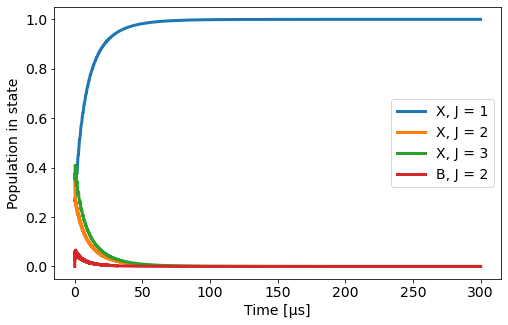

In [69]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

#Plot populations in different J over time
P1 = np.sum(pop_results[:12,:], axis = 0)
P2 = np.sum(pop_results[12:32,:], axis = 0)
P3 = np.sum(pop_results[32:60,:], axis = 0)
PE = np.sum(pop_results[60:,:], axis = 0)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array*1e6, P1, label = 'X, J = 1', lw = 3)
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 3)
ax.plot(t_array*1e6, P3, label = 'X, J = 3', lw = 3)
ax.plot(t_array*1e6, PE, label = 'B, J = 2', lw = 3)
ax.legend(fontsize = 14)
ax.set_xlabel("Time [μs]")
ax.set_ylabel("Population in state")
set_fontsize(ax, 14)

## Parameter scan for RC Laser Power

In [105]:
Main.eval("""
@everywhere params = [val*Γ for val in range(0,1,length = 101)]""")

In [106]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

In [117]:
Main.eval("""
@everywhere begin
    p = [Ωl, νpl, Δ1, Ωμ1, νpμ1, Δ2, Ωμ2, νpμ2, Δ3, 0, 0, 0]
end
""")

In [107]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [108]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i]; p[2:end]])
end
""")

In [109]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [110]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-7, reltol = 1e-4)
sim.elapsedTime
""")

676.3229074

In [115]:
results_Ω = np.array(Main.eval("sim.u"))

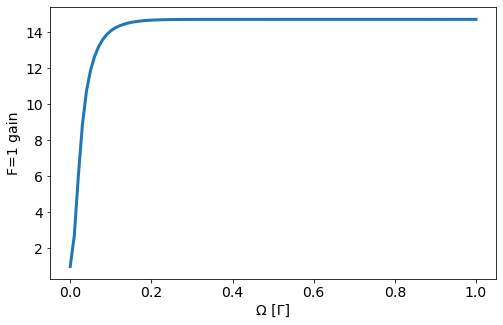

In [116]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, results_Ω[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum(), lw = 3)
ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('F=1 gain')

set_fontsize(ax, 14)

## Parameter scan for RC Laser Power without laser polarization switching

In [119]:
Main.eval("""
@everywhere params = [val*Γ for val in range(0,1,length = 101)]""")

In [120]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

In [121]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [122]:
Main.eval("""
@everywhere begin
    p = [Ωl, 0., Δ1, Ωμ1, νpμ1, Δ2, Ωμ2, νpμ2, Δ3, 0, 0, 0]
end
""")

In [123]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i]; p[2:end]])
end
""")

In [124]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [125]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-7, reltol = 1e-4)
sim.elapsedTime
""")

760.1214573

In [126]:
results_Ω_no_νplaser = np.array(Main.eval("sim.u"))

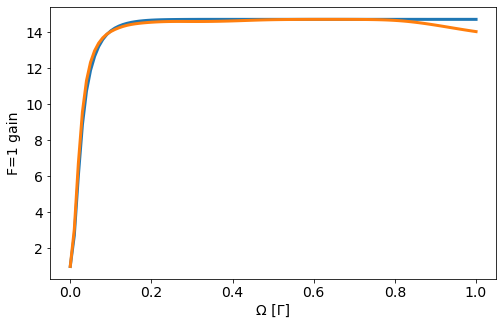

In [127]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, results_Ω[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum(), lw = 3)
ax.plot(Main.params/Γ, results_Ω_no_νplaser[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum(), lw = 3)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('F=1 gain')

set_fontsize(ax, 14)

## Parameter scan for RC Laser Power without laser polarization switching

In [144]:
Ωs = np.linspace(0,1,51)*Γ 
Δϕμs = np.linspace(0,1,11)*np.pi
params = np.array(np.meshgrid(Ωs, Δϕμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [145]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

In [146]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [147]:
Main.eval("""
@everywhere begin
    p = [Ωl, 0., Δ1, Ωμ1, νpμ1, Δ2, Ωμ2, νpμ2, Δ3, 0, 0, 0]
end
""")

In [151]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; 0.; Δ1; Ωμ1; νpμ2; Δ2; Ωμ2; νpμ2; Δ3; 0; 0; params[i,2]])
end
""")

In [152]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [153]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-7, reltol = 1e-4)
sim.elapsedTime
""")

3622.1581434

In [162]:
results_Ω_no_νplaser_Δϕμ = np.array(Main.eval("sim.u"))

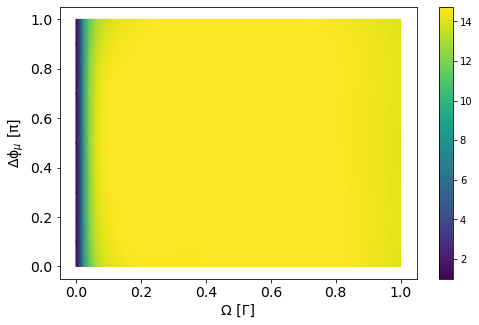

In [189]:
gain = results_Ω_no_νplaser_Δϕμ[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum()

fig, ax = plt.subplots(figsize = (8,5))

# tcf = ax.tricontourf(params[:,0]/Γ, params[:,1]/np.pi, gain)
tcf = ax.tripcolor(params[:,0]/Γ, params[:,1]/np.pi, gain, shading = 'gouraud')
# ax.tricontour(params[:,0]/Γ, params[:,1]/np.pi, gain, colors = 'k', alpha = 0.2)

fig.colorbar(tcf)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel(r'Δϕ$_μ$ [π]')

set_fontsize(ax, 14)

## Parameter scan for Δϕμ

In [235]:
Main.eval("""@everywhere params = [val*π for val in range(0,1,length = 51)]""")

In [236]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

In [237]:
Main.eval("""
@everywhere begin
    p = [0.1Γ, 0, Δ1, Ωμ1, νpμ1, Δ2, Ωμ2, νpμ2, Δ3, 0, 0, 0]
end
""")

In [240]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [241]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[p[1:end-1]; params[i]])
end
""")

In [242]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [243]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-7, reltol = 1e-4)
sim.elapsedTime
""")

326.7778452

In [244]:
results_Δϕμ = np.array(Main.eval("sim.u"))

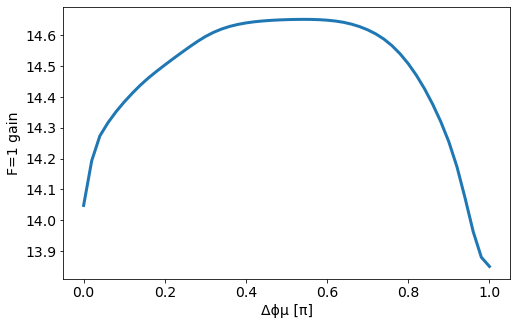

In [245]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/np.pi, results_Δϕμ[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum(), lw = 3)
ax.set_xlabel('Δϕμ [π]')
ax.set_ylabel('F=1 gain')

set_fontsize(ax, 14)